One of the reasons python is so popular for data analysis is the powerful *interactive* environment provided by IPython (that's what the `I` is for after all). That interactivity is key to the data science workflow

![Hadley](figures/ds-cycle.png)
From *R for Data Science* [(Grolemund and Wickham)](http://r4ds.had.co.nz/explore-intro.html)

If it were simply a line from data -> tidy -> transform -> model / visualize -> communicate, we could get by with a language that doesn't have the interactive strengths of Python (or R). But the image is telling, it really is a cycle between modelling, transforming, and visualization.

On a brand new data-set I'm often looking for

- Summary statistics
- Distributions
- Relationships

This is typically done in a Jupyter notebook.
The notebook almost always becomes a mess, so I like to (if the data isn't too large) regularly clear all the output and run it again.
When something has solidified, I like to move it to a regular python file.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import side_by_side, show

pd.options.display.max_rows = 10

If you want to see how I got the data, you can conver the next file to a python cell and execute it.

%load fetch_liquor.py

# Exploratory Analysis

Here's roughly how I would approach a new dataset.

In [2]:
%%time
dtype = {
    'category_name': 'category',
    'city': 'category',
    'county': 'category',
    'item_description': 'category',
    'state': 'category',
    'store_name': 'category',
    'vendor_name': 'category',
    'zip_code': 'category'}

df = pd.read_csv("data/liquor_small.csv.gz", dtype=dtype,
                 parse_dates=['date'])

CPU times: user 12.4 s, sys: 576 ms, total: 13 s
Wall time: 13.2 s


## Inspect data types

Getting dtypes correct early can have big payoffs later on.

In [3]:
df.head()

,date,store_name,address,city,zip_code,store_location,county,category_name,vendor_name,item_description,pack,bottle_volume,state_bottle_cost,state_bottle_retail,bottles_sold,sale,volume_sold
0,2015-01-05,3rd St Convenience,"216, 3RD ST SE",CEDAR RAPIDS,52401,"216, 3RD ST SE\nCEDAR RAPIDS 52401\n(41.977897...",Linn,VODKA 80 PROOF,Laird And Company,Five O'clock Vodka,48,200,$1.13,$1.70,48,$81.60,9.6
1,2015-01-05,3rd St Convenience,"216, 3RD ST SE",CEDAR RAPIDS,52401,"216, 3RD ST SE\nCEDAR RAPIDS 52401\n(41.977897...",Linn,AMERICAN DRY GINS,Pernod Ricard USA/Austin Nichols,Seagrams Extra Dry Gin Mini,12,500,$3.30,$4.95,12,$59.40,6.0
2,2015-01-05,3rd St Convenience,"216, 3RD ST SE",CEDAR RAPIDS,52401,"216, 3RD ST SE\nCEDAR RAPIDS 52401\n(41.977897...",Linn,IMPORTED GRAPE BRANDIES,REMY COINTREAU USA .,Remy Martin 1738 Accord Royal,6,750,$26.99,$40.49,2,$80.98,1.5
3,2015-01-05,3rd St Convenience,"216, 3RD ST SE",CEDAR RAPIDS,52401,"216, 3RD ST SE\nCEDAR RAPIDS 52401\n(41.977897...",Linn,TEQUILA,The Patron Spirits Company,Patron Silver Tequila,12,200,$8.50,$12.75,12,$153.00,2.4
4,2015-01-05,3rd St Convenience,"216, 3RD ST SE",CEDAR RAPIDS,52401,"216, 3RD ST SE\nCEDAR RAPIDS 52401\n(41.977897...",Linn,IMPORTED VODKA,"Bacardi U.S.A., Inc.",Grey Goose Vodka,12,750,$18.49,$27.74,2,$55.48,1.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184483 entries, 0 to 2184482
Data columns (total 17 columns):
date                   datetime64[ns]
store_name             category
address                object
city                   category
zip_code               category
store_location         object
county                 category
category_name          category
vendor_name            category
item_description       category
pack                   int64
bottle_volume          int64
state_bottle_cost      object
state_bottle_retail    object
bottles_sold           int64
sale                   object
volume_sold            float64
dtypes: category(7), datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 191.7+ MB


We notice that the price columns (`state_bottle_cost`, `state_bottle_retail`, and `sale`) are `object` dtype.

In [5]:
df.state_bottle_cost.head()

0     $1.13
1     $3.30
2    $26.99
3     $8.50
4    $18.49
Name: state_bottle_cost, dtype: object

Those dollar signs threw off the parser.

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Write a funciton `from_dollars` that takes a Series with strings like `'$1.70'` and returns a Series with float dtype.

In [6]:
# %load solutions/eda_00.py
def from_dollars(col):
    return pd.to_numeric(col.str.lstrip('$'))


<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Convert the columns `['state_bottle_cost', 'state_bottle_retail', 'sale']` from objects to numeric using `from_dollars`.

In [7]:
# %load solutions/eda_01.py
cols = ['state_bottle_cost', 'state_bottle_retail', 'sale']
df[cols] = df[cols].apply(from_dollars)


### Summary Statistics

You can quickly check things like `.nunique` and `value_counts` to get a since for some magnitudes for discrete variables.

In [8]:
df.category_name.nunique()

73

In [9]:
df.category_name.value_counts()

VODKA 80 PROOF                284434
CANADIAN WHISKIES             216262
STRAIGHT BOURBON WHISKIES     124014
SPICED RUM                    116991
VODKA FLAVORED                115206
                               ...  
AMARETTO - IMPORTED               30
HIGH PROOF BEER - AMERICAN         6
JAPANESE WHISKY                    2
SCHNAPPS - IMPORTED                1
IMPORTED VODKA - CHERRY            1
Name: category_name, dtype: int64

In [10]:
df.vendor_name.nunique()

148

In [11]:
df.item_description.nunique()

2740

In [12]:
pd.options.display.float_format = '{:,.2f}'.format

In [13]:
df[['state_bottle_cost', 'state_bottle_retail', 'sale']].describe()

,state_bottle_cost,state_bottle_retail,sale
count,"2,184,483.00","2,184,483.00","2,184,483.00"
mean,9.82,14.74,130.16
std,14.62,21.93,405.47
min,0.89,1.34,1.34
25%,5.54,8.31,30.72
50%,8.18,12.30,70.56
75%,11.96,17.94,135.36
max,"6,100.00","9,150.00","106,326.00"


In [14]:
df[['bottles_sold', 'volume_sold']].describe()

,bottles_sold,volume_sold
count,"2,184,483.00","2,184,483.00"
mean,9.88,8.98
std,23.69,28.35
min,1.00,0.00
25%,2.00,1.50
50%,6.00,5.25
75%,12.00,10.50
max,"3,960.00","3,960.00"


## Outliers?

$106,326 on liquor sales in a single day?

In [15]:
df.sale.idxmax()

361792

In [16]:
df.loc[df.sale.idxmax()]

date                            2015-03-09 00:00:00
store_name             Hy-Vee #3 / BDI / Des Moines
address                             3221 SE 14TH ST
city                                     DES MOINES
zip_code                                      50320
                                   ...             
state_bottle_cost                             17.90
state_bottle_retail                           26.85
bottles_sold                                   3960
sale                                     106,326.00
volume_sold                                3,960.00
Name: 361792, dtype: object

We can dig into that store's sales. Let's make a `store_id` field.

In [17]:
codes, labels = pd.factorize(df.store_name + df.store_location)
df['store_id'] = codes

In [18]:
store_id = df.loc[df.sale.idxmax(), 'store_id']

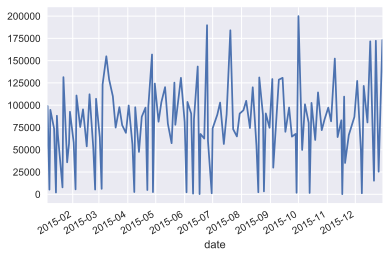

In [19]:
df[df.store_id == 85].groupby('date').sale.sum().sort_values().plot();

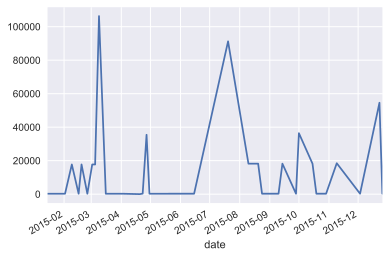

In [20]:
(df[(df.store_id == 85) &
    (df.item_description == 'Jack Daniels Old #7 Black Lbl')]
    .groupby('date').sale.sum().sort_values().plot());

This brings up an important skill (that I personally lack): the ability to move from high-level tasks ("explore this data") to low-level tasks ("What's going on with this single observation?"). I'll often get sidetracked by these distractions.

## Distributions

For continuous variables we can use histograms and kernel density plots to get a sense for how spread out things are.

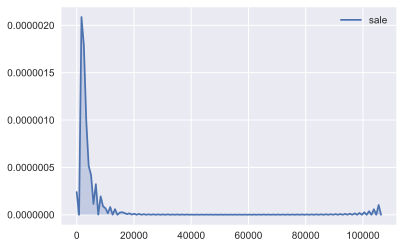

In [21]:
sns.kdeplot(df.sale, shade=True);

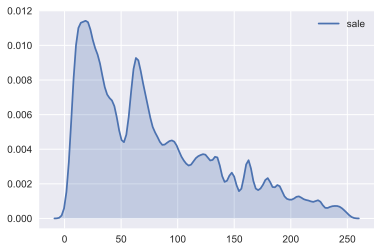

In [22]:
sns.kdeplot(df.sale[df.sale < 250], shade=True);

In [23]:
df.item_description.value_counts()

Black Velvet                              57861
Hawkeye Vodka                             52706
Five O'clock Vodka                        36740
Smirnoff Vodka 80 Prf                     27452
Captain Morgan Spiced Rum                 27342
                                          ...  
Black Saddle Bourbon                          1
Black Tie Bourbon                             1
Crown Royal Hand Selected Barrel #2500        1
Isle Of Jura 10 Yr                            1
Jacquin's Blackberry Brandy                   1
Name: item_description, dtype: int64

Even within items, there's some variation in sale price.

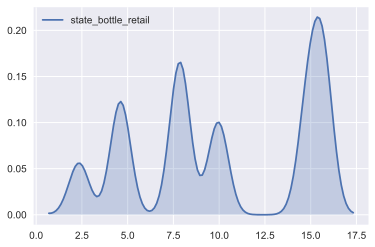

In [24]:
df[df.item_description == 'Black Velvet'].state_bottle_retail.pipe(sns.kdeplot, shade=True);

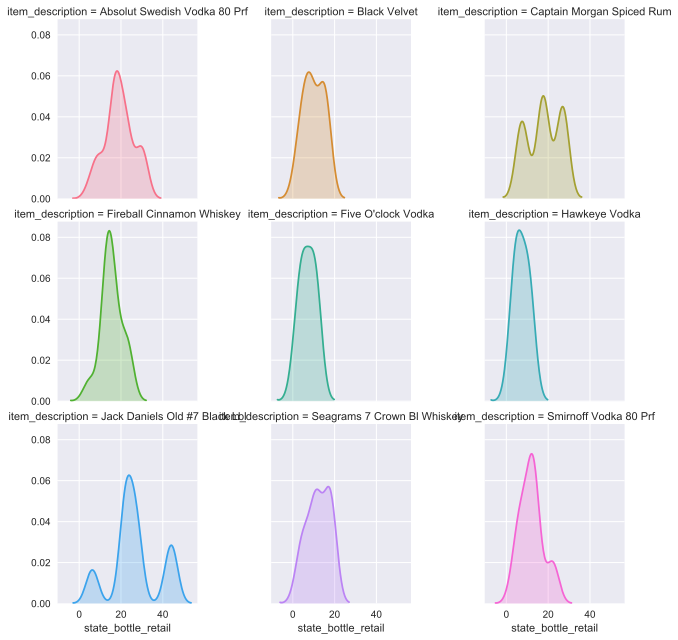

In [25]:
top = df.item_description.value_counts().index[:9]
g = sns.FacetGrid(
    df[df.item_description.isin(top)].assign(
        item_description=lambda x: x.item_description.cat.remove_unused_categories()
    ),  
    col='item_description',
    col_wrap=3, hue='item_description')
g.map(sns.kdeplot, 'state_bottle_retail', shade=True, bw=3).set(ylim=0);

We can do some feature engineering to create additional variables:

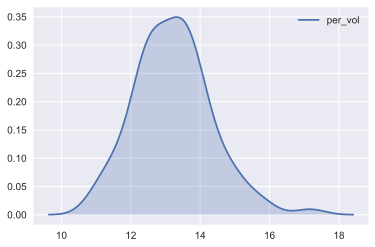

In [26]:
per_vol = df.groupby('county')[['sale', 'volume_sold']].sum().assign(
    per_vol=lambda x: x.sale / x.volume_sold
).per_vol
sns.kdeplot(per_vol, shade=True);

Seaborn is helping a lot here:

In [27]:
cat = df.groupby(['county', 'category_name']).sale.sum().unstack().fillna(0)
cat = cat.div(cat.sum(1), axis=0) * 100

/Users/tom.augspurger/miniconda3/envs/uni/lib/python3.5/site-packages/matplotlib/cbook.py:137: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


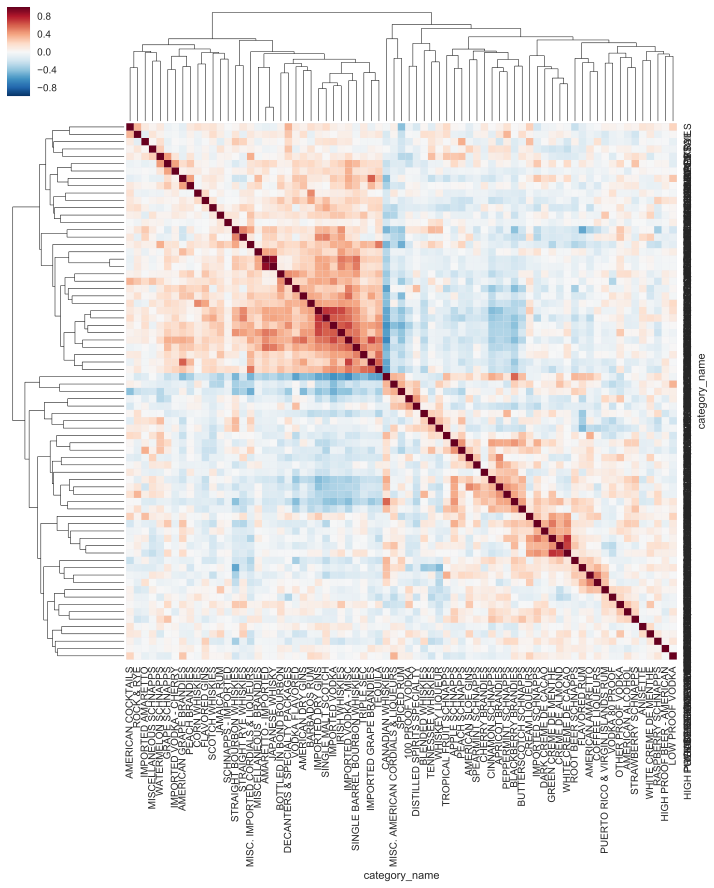

In [28]:
sns.clustermap(cat.corr(), figsize=(12, 12));

This data has some oddities around sales dates:

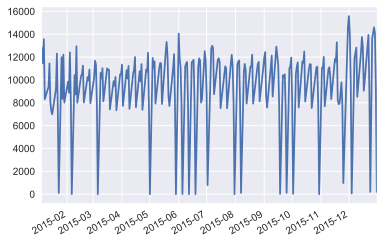

In [29]:
vc = df.date.value_counts().sort_index()
vc.plot();

Simple resampling to weekly frequency doesn't fix things;
There's probably some interaction between the days of the week that fall
in the week / month and the store's reporting schedules

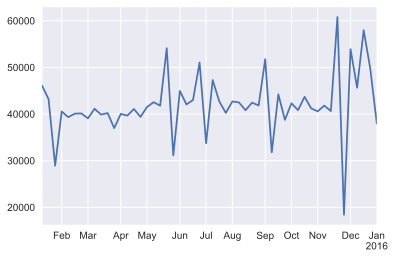

In [30]:
vc.resample("W").sum().plot();

Some kind of reporting artifacts, where sales in one period are reported in another. We would want to smooth this series before using in any statistics.

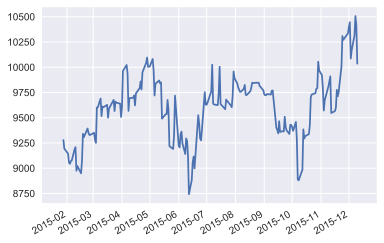

In [31]:
vc.rolling(30, center=True).mean().plot();

## Relating to other datasets

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Find the volume sold per-capita for the [largest cities in Iowa](https://en.wikipedia.org/wiki/List_of_largest_Iowa_cities_by_population)

Fetch the population data from Wikipedia:

In [ ]:
# %load solutions/eda_02.py
url = 'https://en.wikipedia.org/wiki/List_of_largest_Iowa_cities_by_population'
popn = (pd.read_html(url, header=0)[0]
          .set_index("City")
          .rename(lambda x: x.lower()))
popn.head()


Make a barplot of of `volume_sold` per capita by city:

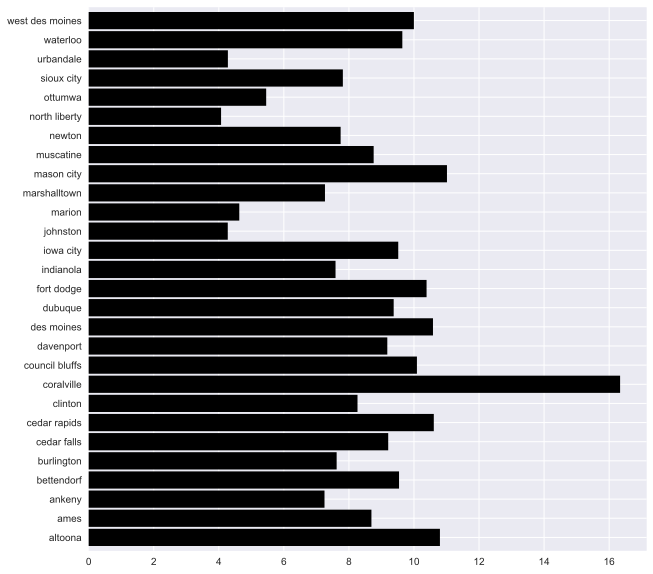

In [33]:
# %load solutions/eda_03.py
per_cap = (df.groupby(df.city.str.lower())
             .volume_sold.sum() /
           popn.Population.astype(float)).dropna()
per_cap.plot.barh(figsize=(10, 10), color='k', width=.9);


Can you plot the relationship between `sale`, `volume_sold`, and `Population`? (sorry for the open-ended question)

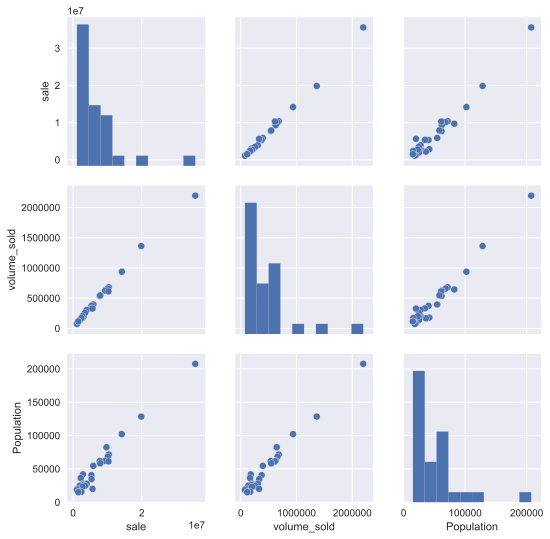

In [34]:
# %load solutions/eda_04.py
pd.concat([df.groupby(df.city.str.lower())[['sale', 'volume_sold']].sum(),
           popn.Population], axis=1, join='inner').pipe(sns.pairplot);


## Population from the Census

I grabbed some data from the Census.

```python
import os
import requests
key = os.environ.get("CENSUS_KEY")


url = ("http://api.census.gov/data/2015/pep/charagegroups?get=GEONAME,COUNTY,AGEGROUP,SEX,POP&"
       "for=county:*&in=state:19&key={KEY}".format(KEY=key))


r = requests.get(url)
cpop = pd.DataFrame.from_records(r.json()[1:], columns=r.json()[0])
cpop.to_csv("data/county_population.csv")
```

In [35]:
cpop = pd.read_csv("data/county_population.csv", index_col=0)
cpop.head()

,GEONAME,COUNTY,AGEGROUP,SEX,POP,state,county
0,"Adair County, Iowa, West North Central, Midwes...",1,0,0,"7,228.00",19,1
1,"Adair County, Iowa, West North Central, Midwes...",1,1,0,330.00,19,1
2,"Adair County, Iowa, West North Central, Midwes...",1,2,0,463.00,19,1
3,"Adair County, Iowa, West North Central, Midwes...",1,3,0,476.00,19,1
4,"Adair County, Iowa, West North Central, Midwes...",1,4,0,398.00,19,1


In [36]:
names = cpop.GEONAME.str.extract("(?P<county>.*) County, Iowa,", expand=False)
cpop['county'] = names
cpop.head()

,GEONAME,COUNTY,AGEGROUP,SEX,POP,state,county
0,"Adair County, Iowa, West North Central, Midwes...",1,0,0,"7,228.00",19,Adair
1,"Adair County, Iowa, West North Central, Midwes...",1,1,0,330.00,19,Adair
2,"Adair County, Iowa, West North Central, Midwes...",1,2,0,463.00,19,Adair
3,"Adair County, Iowa, West North Central, Midwes...",1,3,0,476.00,19,Adair
4,"Adair County, Iowa, West North Central, Midwes...",1,4,0,398.00,19,Adair


Need to be a bit careful with dtypes here; `df.county` is a Categorical.

In [37]:
df.county.dtype, cpop.county.dtype

(category, dtype('O'))

Let's match the codes.

In [38]:
cpop['county'] = pd.Categorical(cpop.county, categories=df.county.cat.categories)
cpop_agg = cpop.groupby("county").POP.sum()
cpop_agg.head()

county
Adair        82,380.90
Adams        42,991.40
Allamakee   156,553.50
Appanoose   141,912.40
Audubon      65,648.50
Name: POP, dtype: float64

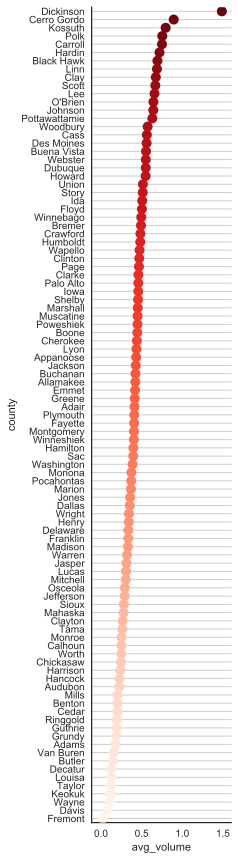

In [39]:
sns.set(style='white')
fig, ax = plt.subplots(figsize=(2.5, 15))
vol_pc = (df.groupby('county').volume_sold.sum() / cpop_agg)
sns.stripplot(x="avg_volume",
              y="county",
              data=vol_pc.to_frame(name="avg_volume").reset_index(),
              order=vol_pc.sort_values(ascending=False).index,
              orient="h",
              size=10,
              palette="Reds_r",
              ax=ax);
ax.xaxis.grid(False)
ax.yaxis.grid(True)
sns.despine()

I've included a section for making a choropleth map. I don't think you should use vincent these days. Rob doesn't have time to maintain it anymore, and Altair is better in most situations. But Altiar / Vega-Lite don't support maps and projections yet, so we'll use Vincent.

In [40]:
import json

In [41]:
with open('data/counties.json') as f:
    d = json.load(f)

In [42]:
fips = pd.Series(
    {x['properties']['COUNTY']: x['properties']['FIPS']
     for x in d['objects']['counties']['geometries']
     if x['properties']['STATE'] == "IA"},
    dtype=str)
fips.index = fips.index.str.extract("(.*) County$", expand=False)
fips

Adair         19001
Adams         19003
Allamakee     19005
Appanoose     19007
Audubon       19009
              ...  
Winnebago     19189
Winneshiek    19191
Woodbury      19193
Worth         19195
Wright        19197
dtype: object

In [43]:
data = pd.concat([vol_pc, fips], axis=1, keys=['vol_pc', 'FIPS'])
data.head()

,vol_pc,FIPS
county,,
Adair,0.41,19001
Adams,0.18,19003
Allamakee,0.42,19005
Appanoose,0.43,19007
Audubon,0.23,19009


In [44]:
import vincent
from vincent import Map, ValueRef
vincent.initialize_notebook()

In [46]:
geo_data = [{'name': 'counties',
             'url': 'data/counties.json',
             'feature': 'counties'}]

vis = Map(data=data,
          geo_data=geo_data, scale=8000, projection='albersUsa',
          data_bind='vol_pc', data_key='FIPS',
          map_key={'counties': 'properties.FIPS'},
          translate=[100, 725])
vis.marks[0].properties.enter.stroke_opacity = ValueRef(value=0.5)
vis.scales[0].type='threshold'
vis.scales['color'].domain = [0, .25, .5, .75, 1, 1.5]
vis.legend(title='Volume Per Capita')
vis.to_json('vega.json')

In [47]:
vis.display()

I was going to look at the variation preferences according to variance in age and sex, but apparently there's no heterogenity across Iowa's counties

In [48]:
age = cpop.groupby(['county', 'AGEGROUP']).POP.sum().unstack()
age = age.div(age.sum(1), axis=0) * 100
age.head()

AGEGROUP,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
county,,,,,,,,,,,,,,,,,,,,,
Adair,17.55,0.80,1.12,1.16,0.97,0.87,0.88,0.92,0.96,0.87,...,9.85,1.19,3.62,5.04,3.97,0.85,14.28,13.82,5.46,0.17
Adams,17.66,1.16,1.10,0.88,0.99,0.82,0.91,0.95,0.86,0.87,...,9.91,1.18,3.59,5.15,3.97,0.60,14.29,13.88,5.40,0.32
Allamakee,17.74,1.09,1.16,1.08,0.99,0.93,0.83,0.88,0.88,0.88,...,9.89,1.28,3.48,5.13,3.89,0.55,14.21,13.78,5.40,0.09
Appanoose,17.66,1.03,1.15,1.09,0.94,0.93,0.91,0.98,0.91,0.93,...,9.96,1.25,3.73,4.98,3.81,0.57,14.18,13.77,5.60,0.09
Audubon,17.59,0.86,0.99,1.00,1.07,0.94,0.75,0.79,0.82,0.81,...,9.70,1.29,3.17,5.24,4.31,0.89,14.52,14.01,5.18,0.22


<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Group Exercise</h1>
</div>

Suggest other interesting questions we might be able to answer with this dataset.
We'll work through one or two togehter.

For example,

- Are there any vendors that earn a high proportion of revenue across multiple categories?